In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import re
import seaborn as sns

/tmp/ipykernel_7740/2870207811.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load Files

In [2]:
# Read all columns and concatenate them into a single dataframe
df = pd.read_csv("new_raw_data.csv", header = 0, sep="\t", index_col=0)

In [3]:
df.columns

Index(['ISSN', 'JIF', 'Eigenfactor', 'Year Published', 'Authors',
       'Document Title', 'Publication Name', 'Author Keywords', 'Abstract',
       'Author Address', 'Reprint Address', 'Funding Agency and Grant Number',
       'Cited Reference Count', 'Times cited', 'Usage Count (Last 180 Days)',
       'Usage Count (Since 2013)', 'Publisher Address', 'Page Count',
       'Web of Science Categories', 'eISSN'],
      dtype='object')

In [4]:
df.describe()

,JIF,Eigenfactor,Year Published,Cited Reference Count,Times cited,Usage Count (Last 180 Days),Usage Count (Since 2013),Page Count
count,4538.000000,1709.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000
mean,4.099712,0.061269,2010.590128,39.270383,34.288233,0.408109,9.252534,9.421992
std,2.210854,0.120082,6.723279,17.801153,50.767547,1.129306,12.992551,3.565344
min,0.193000,0.001000,2000.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,2.524000,0.014000,2005.000000,27.000000,9.000000,0.000000,3.000000,7.000000
50%,3.641000,0.033000,2010.000000,37.000000,19.000000,0.000000,6.000000,9.000000
75%,5.115000,0.060000,2016.000000,48.000000,39.000000,0.000000,12.000000,11.000000
max,17.202000,1.540000,2022.000000,273.000000,833.000000,26.000000,271.000000,38.000000


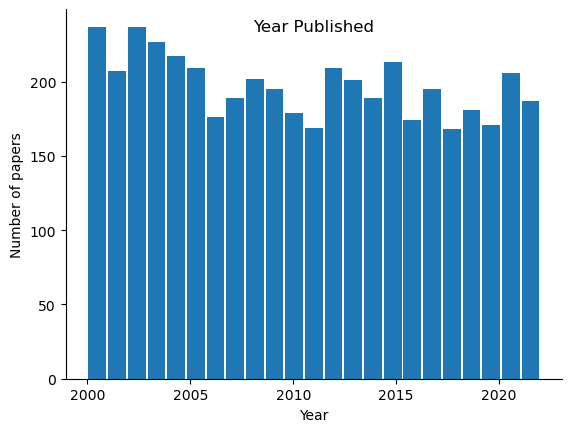

In [5]:
fig, ax = plt.subplots()
ax.hist(df['Year Published'], bins=23, rwidth=0.9)
ax.set_title('Year Published', y=1.0, pad=-16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Year')
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'year_hist.png')
fig.savefig(fig_path, dpi=100)

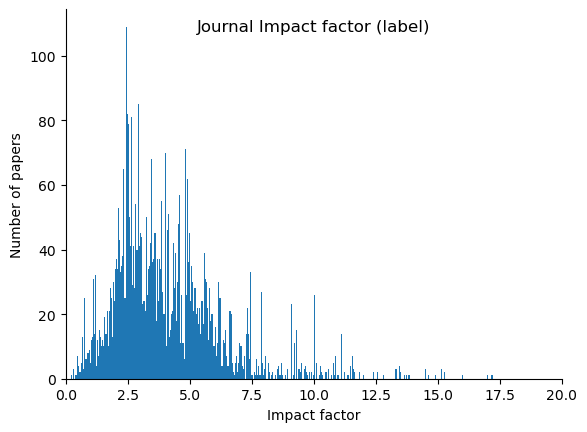

In [6]:
features = ['Year Published', 'JIF', 'Page Count', 'Times cited']
fig, ax = plt.subplots()

ax.hist(df[features[1]], bins=400)
ax.set_title('Journal Impact factor (label)', y=1.0, pad=-16)
ax.set_xlim(0,20)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Impact factor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'JIF_hist.png')
fig.savefig(fig_path, dpi=100)

In [19]:
df['JIF'].describe()

count    4538.000000
mean        4.099712
std         2.210854
min         0.193000
25%         2.524000
50%         3.641000
75%         5.115000
max        17.202000
Name: JIF, dtype: float64

In [20]:
df['JIF'].count()

4538

In [7]:
categories = df['Web of Science Categories'].apply(lambda x: x.split(';')).explode()
categories = categories.apply(lambda x: x.strip())
categories = categories.apply(lambda x: 'Chemistry' if 'Chemistry' in x else x)
categories = categories.apply(lambda x: 'Biochemistry' if 'Biochemi' in x else x)
categories = categories.apply(lambda x: 'Neurosciences' if 'Neuro' in x else x)
categories.groupby(categories).size().sort_values(ascending=False).head(10)

Web of Science Categories
Chemistry                                        1685
Pharmacology & Pharmacy                          1232
Neurosciences                                    1177
Biochemistry                                     1059
Radiology, Nuclear Medicine & Medical Imaging     990
Psychiatry                                        195
Endocrinology & Metabolism                        167
Multidisciplinary Sciences                        137
Oncology                                          106
Medicine, Research & Experimental                  87
Name: Web of Science Categories, dtype: int64

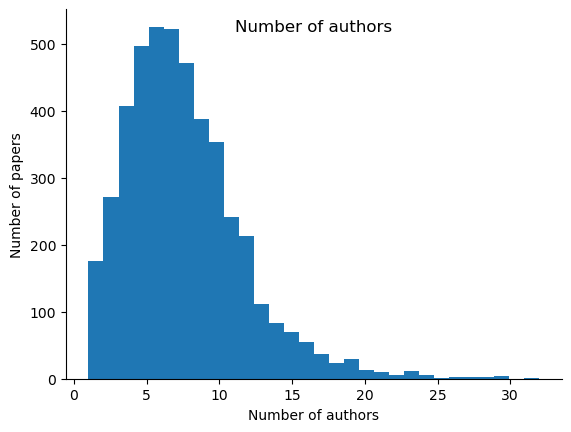

In [8]:
df['num_auth'] = df['Authors'].apply(lambda x: len(x.split(';')))
fig, ax = plt.subplots()
ax.hist(df['num_auth'], bins=30)
ax.set_title('Number of authors', y=1.0, pad=-16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Number of authors')
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'Num_auth.png')
fig.savefig(fig_path, dpi=100)

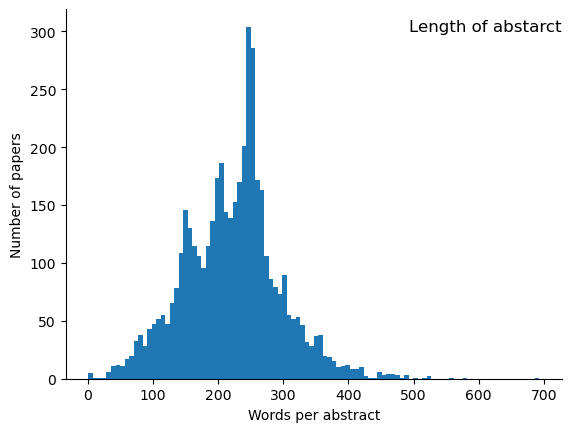

In [9]:
df['num_words'] = df['Abstract'].apply(lambda x: len(str(x).split(' ')))
fig, ax = plt.subplots()
ax.hist(df['num_words'], bins=100)
ax.set_title('Length of abstarct', y=1.0, loc='right', pad=-16)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Words per abstract')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'Abs_len.png')
fig.savefig(fig_path, dpi=100)

In [21]:
df['num_words'].describe()

count    4538.000000
mean      221.725209
std        73.956835
min         1.000000
25%       171.000000
50%       227.000000
75%       262.000000
max       693.000000
Name: num_words, dtype: float64

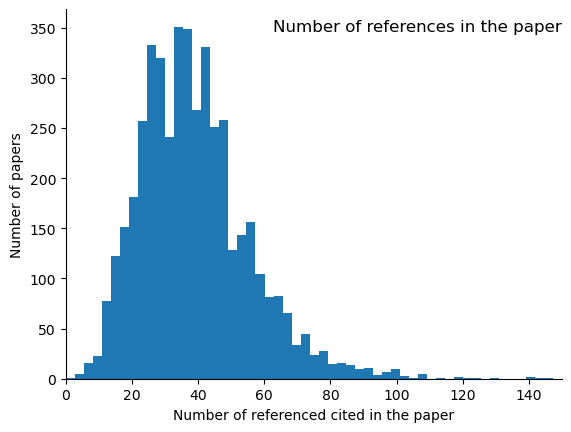

In [10]:
fig, ax = plt.subplots()
ax.hist(df['Cited Reference Count'], bins=100)
ax.set_title('Number of references in the paper', loc='right', y=1.0, pad=-16)
ax.set_xlim(0,150)
ax.set_ylabel('Number of papers')
ax.set_xlabel('Number of referenced cited in the paper')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

fig_path = os.path.join('.', 'report_latex', 'Images', 'Num_ref.png')
fig.savefig(fig_path, dpi=100)

In [11]:
def remove_authors(input_string):
    pattern = re.compile(r'\[.*?\]')
    result_string = re.sub(pattern, '  ', input_string)
    country_set = {address.split(',')[-1].strip() for address in result_string.split(';')}
    country_set_clean = set()
    for contry in country_set:
       if 'usa' in contry.lower(): country_set_clean.add('USA')
       elif 'states' in contry.lower(): country_set_clean.add('USA')
       elif 'england' in contry.lower(): country_set_clean.add('UK')
       elif 'scotland' in contry.lower(): country_set_clean.add('UK')
       elif 'china' in contry.lower(): country_set_clean.add('China')
       elif 'zech' in contry.lower(): country_set_clean.add('Czech Rep.')
       else: country_set_clean.add(contry.rstrip('.'))

    return list(country_set_clean)[0]

In [12]:
df['Auth_country'] = df['Reprint Address'].apply(lambda x: remove_authors(str(x)))

/tmp/ipykernel_7740/1651076940.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axin.set_xticklabels(to_plot_c.index, rotation = 90)
/tmp/ipykernel_7740/1651076940.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(to_plot.index, rotation = 90)


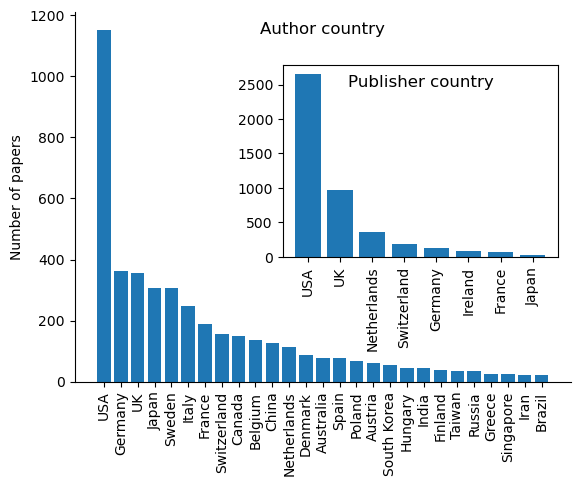

In [13]:

Auth_country_ser = df['Author Address'].astype(str).apply(lambda x: remove_authors(x)).explode()
to_plot = Auth_country_ser.groupby(Auth_country_ser).size().sort_values(ascending=False)
to_plot = to_plot[to_plot.values > 20]
fig, ax = plt.subplots()
ax.bar(x = to_plot.index, height = to_plot.values)
ax.set_title('Country of origin')


df['Pub_country'] = df['Publisher Address'].apply(lambda x: x.split(',')[-1].split(' ')[-1].title())
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'USA' if 'usa' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'USA' if 'states' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'UK' if 'ngland' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'UK' if 'scotland' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'New Zealand' if 'zealand' in x.lower() else x)
to_plot_c = df['Pub_country'].groupby(df['Pub_country']).size().sort_values(ascending=False)
to_plot_c = to_plot_c[to_plot_c.values > 20]
axin = fig.add_axes([0.45, 0.37, 0.43, 0.4])
axin.bar(x = to_plot_c.index, height = to_plot_c.values)
axin.set_xticklabels(to_plot_c.index, rotation = 90)
axin.set_title('Publisher country', y=1.0, pad=-16)
ax.set_title('Author country', y=1.0, pad=-16)
ax.set_xticklabels(to_plot.index, rotation = 90)
ax.set_ylabel('Number of papers')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
fig_path = os.path.join('.', 'report_latex', 'Images', 'Countries.png')
fig.savefig(fig_path, dpi=100)

In [14]:
to_plot

Author Address
USA            1153
Germany         361
UK              357
Japan           308
Sweden          306
Italy           248
France          190
Switzerland     155
Canada          150
Belgium         135
China           126
Netherlands     112
Denmark          86
Australia        77
Spain            76
Poland           67
Austria          60
South Korea      55
Hungary          45
India            45
Finland          39
Taiwan           36
Russia           34
Greece           24
Singapore        24
Iran             22
Brazil           21
Name: Author Address, dtype: int64

In [15]:
df['Pub_country'].groupby(df['Pub_country']).size().sort_values(ascending=False)

Pub_country
USA            2653
UK              965
Netherlands     354
Switzerland     188
Germany         130
Ireland          86
France           67
Japan            34
Australia        17
China            16
Poland            9
Emirates          6
Greece            4
Austria           2
New Zealand       2
Italy             1
Korea             1
Russia            1
Spain             1
Canada            1
Name: Pub_country, dtype: int64

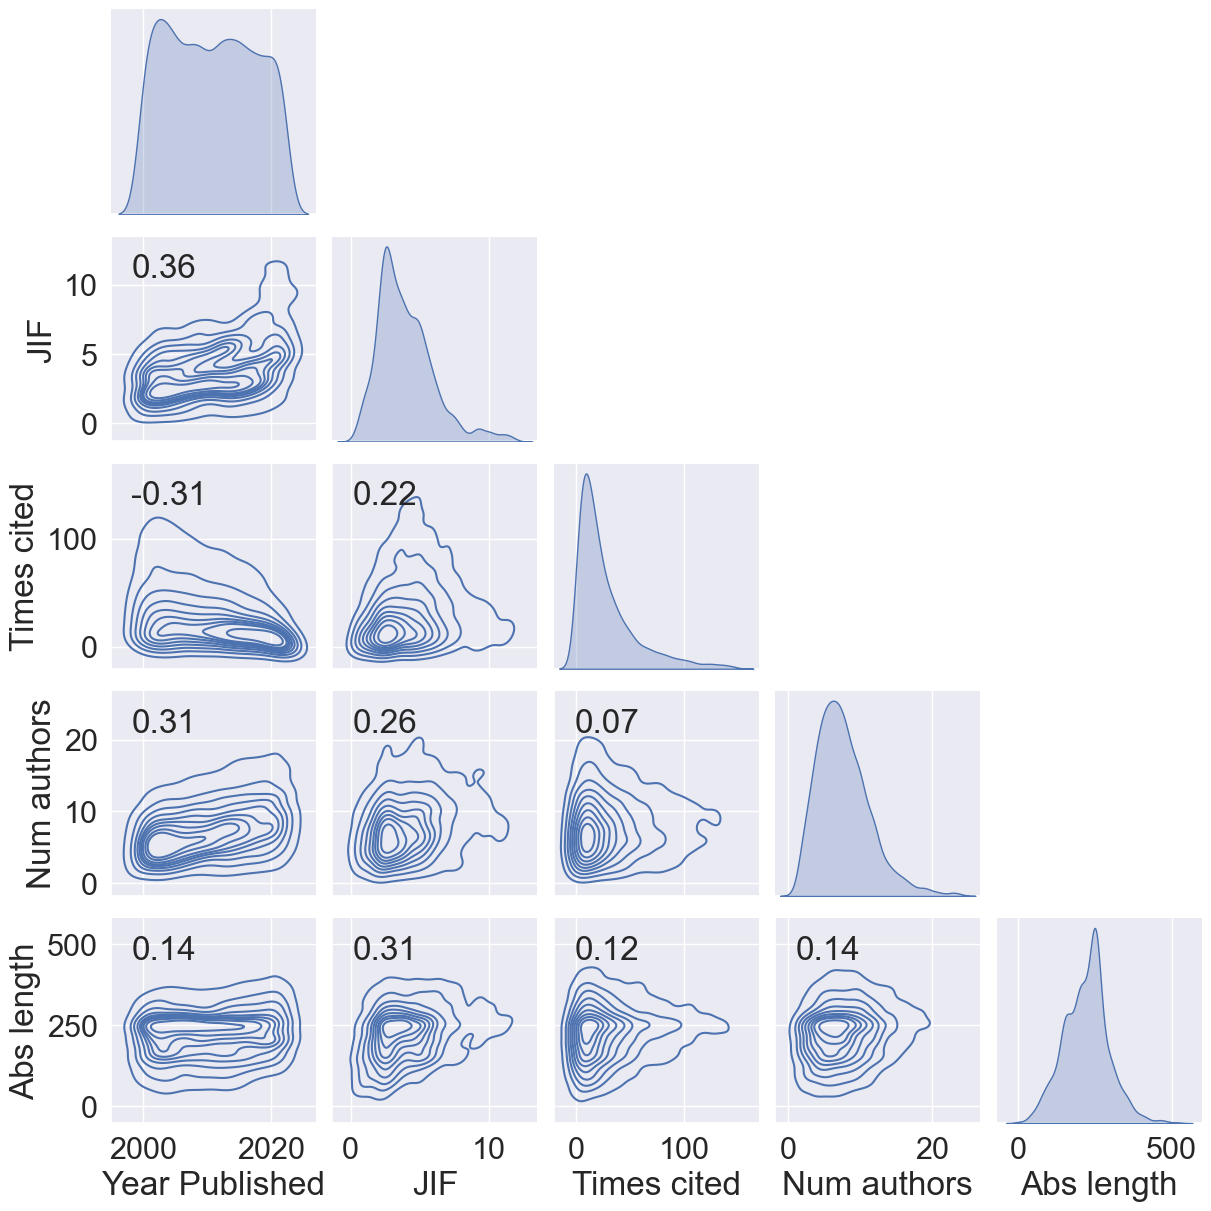

In [16]:
#Prep data
df_clean = df[['Year Published', 'JIF', 'Cited Reference Count', 'Times cited', 'Page Count', 'num_auth', 'num_words', 'Pub_country']]
df_clean.columns = ['Year Published', 'JIF', 'Num references', 'Times cited', 'Page Count', 'Num authors', 'Abs length', 'Pub_country']
df_clean = df_clean[df_clean['Num references']<110]
df_clean = df_clean[df_clean['JIF']<12]
df_clean = df_clean[df_clean['Abs length']<550]
df_clean = df_clean[df_clean['Num authors']<25]
df_clean = df_clean[df_clean['Times cited']<150]

from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'{r:.2f}', xy=(.1, .8), xycoords=ax.transAxes)


#Draw the plot
sns.set(font_scale=2)
pairplot = sns.pairplot(df_clean[['Year Published', 'JIF', 'Times cited', 'Num authors', 'Abs length']], corner=True, kind="kde")
pairplot.map_lower(corrfunc)

#Save the picture
fig = pairplot.figure
fig_path = os.path.join('.', 'report_latex', 'Images', 'Pairplot.png')
fig.savefig(fig_path, dpi=100)
pairplot

In [17]:
# Convert funding to categorical
df['Funding'] = df['Funding Agency and Grant Number'].notna()

In [18]:
df_features = df[['JIF', 'Year Published', 'Abstract', 'Funding',
       'Cited Reference Count', 'Times cited', 'Usage Count (Since 2013)', 'Page Count', 'num_auth', 'num_words',
       'Auth_country', 'Pub_country', 'Document Title', 'Publication Name', 'Author Keywords']]

#Drop abstracts that are too short, below 20 sympols
df_features['Abstract'] = df_features['Abstract'].apply(lambda x: str(x))
df_features['len'] = df_features['Abstract'].apply(lambda x: len(x))
df_features.drop(df_features[df_features['len']<50].index, inplace=True)
df_features.drop(['len'],axis = 1, inplace=True)


df_features.to_csv('features.csv', '\t')

/tmp/ipykernel_7740/1052856817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['Abstract'] = df_features['Abstract'].apply(lambda x: str(x))
/tmp/ipykernel_7740/1052856817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['len'] = df_features['Abstract'].apply(lambda x: len(x))
/tmp/ipykernel_7740/1052856817.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc